In [87]:
# operating system interface
import os

# to deal with the matrices of the images
import numpy as np

# to load images
from PIL import Image

# neural network framework
import tensorflow as tf

# to visualize
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import display,clear_output

# Images pre-processing

In [16]:
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400
COLOR_CHANNELS = 3 #(RGB)

In [2]:
madryn_original = Image.open('Madryn_1.jpg')          # Content Image
van_gogh_original = Image.open('van_gogh.jpg')        # Style image

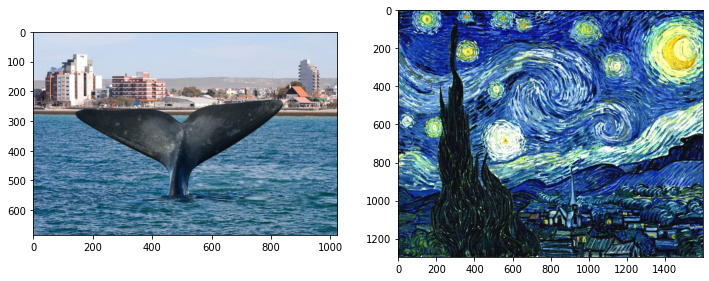

In [3]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(madryn_original)
ax[1].imshow(van_gogh_original)

In [4]:
van_gogh_original.size, madryn_original.size

((1600, 1296), (1024, 685))

In [ ]:
# Aspect ratios
van_gogh_original.size[1] / van_gogh_original.size[0], madryn_original.size[1] / madryn_original.size[0]

In [5]:
# We crop the images to make them have the same aspect ratio (0.75)
madryn_crop = madryn_original.crop((56,1,968,685))
van_gogh_crop = van_gogh_original.crop((0,48,1600,1248))

In [6]:
# We make the resolution the same
content_image = madryn_crop.resize((400,300))
style_image = van_gogh_crop.resize((400,300))

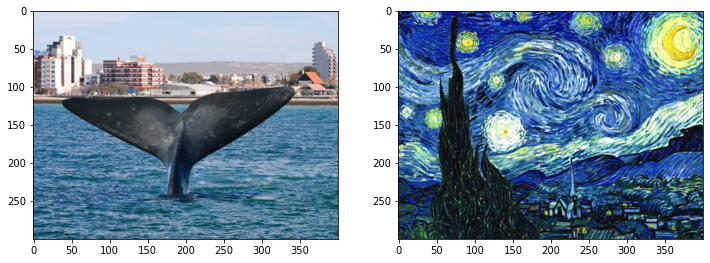

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(content_image)
ax[1].imshow(style_image)

In [ ]:
# Save the content and style image

# as jpg
Image.Image.save(content_image,'ballena_.jpg')
Image.Image.save(style_image,'van_gogh_.jpg')

# as a numpy array
np.save('content_image.npy',content_image)
np.save('style_image.npy',style_image)

In [9]:
# Load the images as numpy arrays
content_image = np.load('content_image.npy')
style_image = np.load('style_image.npy')

In [13]:
content_image.shape, style_image.shape   # matrix size of the images (RGB format)

((300, 400, 3), (300, 400, 3))

In [55]:
# Introduce random noise into the content image
def generate_noise_image(content_image, noise_ratio = 0.8):
    noise_image = np.random.rand(IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS).astype('float32')
    input_image = (noise_image* 255 * noise_ratio) + (noise_image * content_image * (1 - noise_ratio))
    input_image = tf.clip_by_value(input_image,0.,255.)
    return input_image.numpy().astype('uint8')

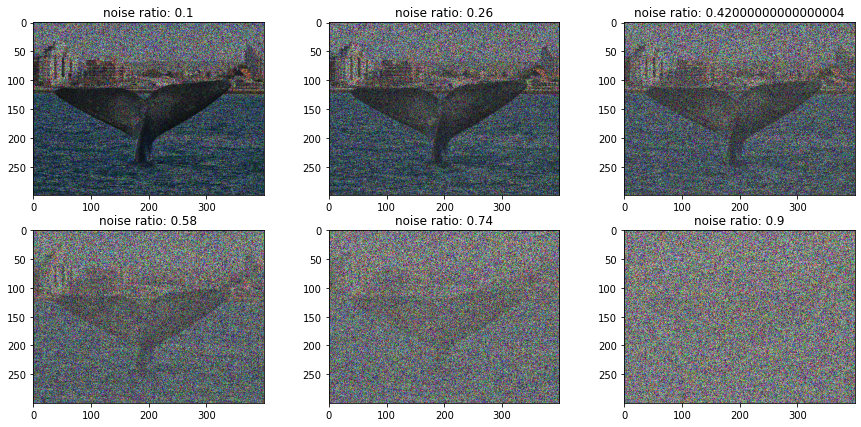

In [56]:
fig,axs = plt.subplots(2,3,figsize=(15,7))
axs = axs.ravel() 

for i,noise_ratio in enumerate(np.linspace(0.1,0.9,6)):
    axs[i].imshow(generate_noise_image(content_image, noise_ratio = noise_ratio))
    axs[i].set_title(f'noise ratio: {noise_ratio}')

In [57]:
# input_image: image that is gonna be iteratively modified
input_image = generate_noise_image(content_image, noise_ratio = 0.1)

### vgg19. preprocess_input returns the images converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

In [58]:
# Preprocessing for specific use in the VGG19
content_image_prepross = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(content_image,axis=0))
style_image_prepross = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(style_image,axis=0))
input_image_preprocess = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(input_image,axis=0))

Text(0.5, 1.0, 'preprocessed input image')

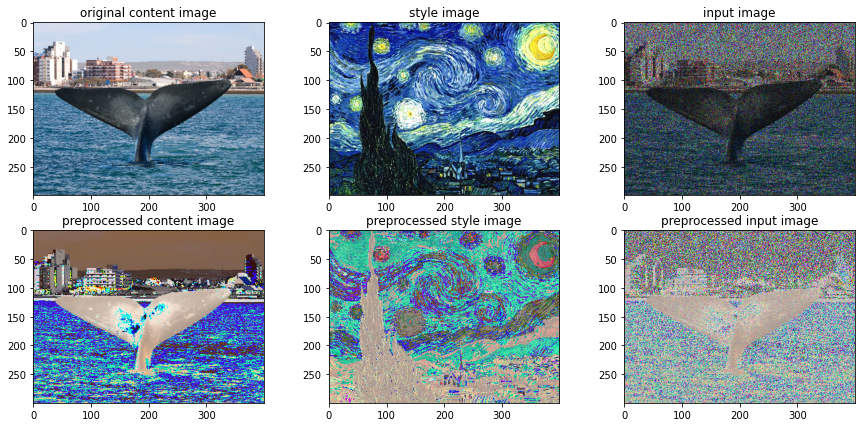

In [59]:
fig,ax = plt.subplots(2,3,figsize=(15,7))
ax[0][0].imshow(content_image)
ax[0][0].set_title('original content image')

ax[0][1].imshow(style_image)
ax[0][1].set_title('style image')

ax[0][2].imshow(input_image.astype('uint8'))
ax[0][2].set_title('input image')

ax[1][0].imshow(content_image_prepross[0].astype('uint8'))
ax[1][0].set_title('preprocessed content image')
ax[1][1].imshow(style_image_prepross[0].astype('uint8'))
ax[1][1].set_title('preprocessed style image')
ax[1][2].imshow(input_image_preprocess[0].astype('uint8'))
ax[1][2].set_title('preprocessed input image')

# Create a neural network model

In [61]:
VGG_BIASES = tf.keras.applications.vgg19.preprocess_input(np.zeros((3)))

In [62]:
VGG_BIASES

array([-103.939, -116.779, -123.68 ])

In [85]:
def deprocess_image(image):   #tf.keras.backend.flatten(x)
    aaa = image[0]
    a_shape = aaa.shape
    aaa = np.column_stack((tf.keras.backend.flatten(aaa[:,:,2]),tf.keras.backend.flatten(aaa[:,:,1]),tf.keras.backend.flatten(aaa[:,:,0]))).reshape(a_shape)
    aaa = aaa - np.array([-123.68, -116.779 ,-103.939 ])
    aaa = aaa.astype('uint8')
    return aaa

In [66]:
layer_content = ['block4_conv2']
#layers_style = ['block1_conv1','block1_conv2','block2_conv1','block2_conv2','block3_conv1','block3_conv2','block3_conv3','block3_conv4','block4_conv1','block4_conv2','block4_conv3','block4_conv4','block5_conv1','block5_conv2','block5_conv3'] # 13
#layers_style = ['block2_conv1','block3_conv1','block3_conv3','block3_conv4','block4_conv1','block4_conv3','block4_conv4','block5_conv1','block5_conv3']  # 9
#layers_style = ['block1_conv1','block2_conv1','block3_conv1','block3_conv2','block4_conv1','block4_conv2','block5_conv1']

# full block 4 and 5
#layers_style = ['block4_conv1','block4_conv2','block4_conv3','block4_conv4','block5_conv1','block5_conv2','block5_conv3'] # 7

# blocks from 1 to 3
#layers_style = ['block1_conv1','block1_conv2','block2_conv1','block2_conv2','block3_conv1','block3_conv2','block3_conv3','block3_conv4']

# FIRST OF EACH
layers_style = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

# LAST OF EACH
#layers_style = ['block1_conv2','block2_conv2','block3_conv4','block4_conv4','block4_conv5']

#some of each, no extremes
#layers_style = ['block2_conv1','block3_conv1','block3_conv4','block4_conv1','block4_conv2','block4_conv3','block4_conv4','block5_conv1']

In [67]:
def make_model():
    base_model = tf.keras.applications.VGG19(weights='imagenet',include_top=False)
    base_model.trainable=False
    output_layers = [base_model.get_layer(layer).output for layer in layer_content + layers_style]
    return tf.keras.models.Model(base_model.input,output_layers)

In [68]:
model = make_model()

In [69]:
cont_feat = model(content_image_prepross)
style_feat = model(style_image_prepross)
input_feat = model(input_image_preprocess)

In [70]:
style_feat[1].get_shape().as_list()

[1, 300, 400, 64]

In [ ]:
def get_content_loss(content_feat,new_feat):
    m,n_H,n_W,n_C = content_feat.shape
    return (tf.reduce_sum(tf.square(new_feat - content_feat))) / (4*n_C*n_H*n_W)

In [72]:
get_content_loss(input_feat[0],cont_feat[0])

<tf.Tensor: id=2071, shape=(), dtype=float32, numpy=103139.42>

In [74]:
def get_gram_matrix(A):
    m,n_H,n_W,n_C = A.shape
    A = tf.reshape(A, shape=[n_C, -1]) 
    gram_matrix = tf.matmul(A,tf.transpose(A))
    n = gram_matrix.shape[0]
    return  gram_matrix / tf.cast(n,'float32'), n 

In [75]:
get_gram_matrix(input_feat[0])

(<tf.Tensor: id=2079, shape=(512, 512), dtype=float32, numpy=
 array([[4887858.5 ,  935373.8 ,  682319.25, ...,  695989.94,  750455.44,
          906001.1 ],
        [ 935373.8 , 3401669.  ,  737492.  , ...,  573290.06,  658929.1 ,
          686717.9 ],
        [ 682319.25,  737492.  , 3209377.5 , ...,  509767.53,  564170.44,
          664574.8 ],
        ...,
        [ 695990.  ,  573290.06,  509767.5 , ..., 2022997.5 ,  441259.62,
          586931.06],
        [ 750455.44,  658929.1 ,  564170.44, ...,  441259.62, 2254714.8 ,
          573556.3 ],
        [ 906001.1 ,  686717.9 ,  664574.8 , ...,  586931.06,  573556.3 ,
         2805700.2 ]], dtype=float32)>,
 512)

In [76]:
def get_style_loss(new_,style_): #for one layer
    m,n_H,n_W,n_C = new_.shape
    gram_original,original_number = get_gram_matrix(style_)
    gram_new,new_number = get_gram_matrix(new_)

    assert new_number == original_number, 'dimension are wrong'
    loss = tf.reduce_sum(tf.square(gram_new - gram_original))  / (2*n_C*n_H*n_W)**2
    return loss

In [77]:
weights = [0.5,
          0.3,
          0.2,
          0.2,
          0.2]

In [78]:
def get_total_loss(new_,content_,style_,alpha_style,alpha_content): 
    new_style = new_[len(layer_content):]
    style_style = style_[len(layer_content):]
    style_loss = 0
    N = len(new_style)
    for i in range(N):
        style_loss += weights[i] * get_style_loss(new_style[i],style_style[i])
    style_loss = style_loss 
    
    new_content = new_[:len(layer_content)]
    content_content = content_[:len(layer_content)]
    content_loss = 0
    N = len(content_content) 
    for i in range(N):
        content_loss += get_content_loss(content_content[i],new_content[i])
    content_loss = content_loss / N    
    
    #total_cost = ((1 - alpha) * style_loss) + (alpha * content_loss)
    total_cost = ((alpha_style * style_loss) + (alpha_content * content_loss))
    
    return total_cost

In [79]:
len(style_feat)

6

In [81]:
cont_feat = model(content_image_prepross)
style_feat = model(style_image_prepross)
generated_feat = tf.Variable(input_image_preprocess,dtype='float32')

In [82]:
optimizer = tf.optimizers.Adam(learning_rate=8.)#,epsilon=1e-3) # last try lr=5  #,beta_1=0.99,

In [91]:
images = []
loss = []
i=0
best_loss = 100000000
min_vals = VGG_BIASES
max_vals = VGG_BIASES + 255

for i in range(4000):
    with tf.GradientTape() as tape:
        tape.watch(generated_feat)
        content_output = model(generated_feat)
        loss = get_total_loss(content_output,cont_feat,style_feat,alpha_style=1e5,alpha_content=1e2) # control alpha from here
        grad = tape.gradient(loss,generated_feat)
        optimizer.apply_gradients(zip([grad],[generated_feat]))
        clipped = tf.clip_by_value(generated_feat,min_vals,max_vals)
        generated_feat.assign(clipped)
        print(f'iteration number {i}')
        if i < 20:
            im = Image.fromarray(deprocess_image(generated_feat))
            im.save(f'{i}.png')
        if i % 10 == 0:
            images.append(deprocess_image(generated_feat))
            im = Image.fromarray(deprocess_image(generated_feat))
            im.save(f'{i}.png')
            #plt.imsave(f'{i}.png', deprocess_image(generated_feat).astype('uint8'))
        if loss < best_loss:
            best_image = generated_feat
            best_loss = loss
            print(f'iteration number {i}: loss = {best_loss}')
        display(loss)
        clear_output(wait=True)

KeyboardInterrupt: 

Text(0.5, 1.0, 'style image')

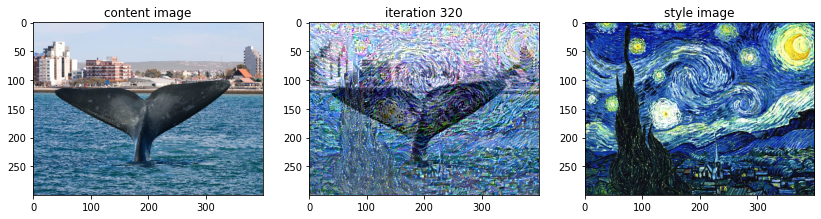

In [114]:
fig,axs = plt.subplots(1,3,figsize=(14
                                    ,10))
axs = axs.ravel()


axs[0].imshow(content_image)
axs[0].set_title('content image')

image = Image.open('320.png')
axs[1].imshow(image)
axs[1].set_title('iteration 320')

axs[2].imshow(style_image)
axs[2].set_title('style image')